<a href="https://colab.research.google.com/github/Shristy0412/Analysis-of-Epigenetic-Modifications/blob/main/Cancer_epigenetics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path='/content/flattened_data.xlsx'


In [3]:
df=pd.read_excel(file_path)

In [4]:
# Handle missing values (Replace zeros with NaN or another strategy)
df.replace(0, np.nan, inplace=True)  # Replace 0 with NaN to handle missing data

In [6]:
# Separate the tumor and normal columns
tumor_values = df['T'].dropna().values  # Only take non-null values
normal_values = df['N'].dropna().values  # Only take non-null values

In [7]:
#Create the labels
# Tumor: Label 1, Normal: Label 0
tumor_labels = [1] * len(tumor_values)
normal_labels = [0] * len(normal_values)

In [8]:
# Combine the data
# Create a combined dataset with features and labels
combined_values = np.concatenate([tumor_values, normal_values])
combined_labels = np.concatenate([tumor_labels, normal_labels])

In [9]:
# Convert to DataFrame
combined_df = pd.DataFrame({
    'CpG_values': combined_values,
    'Label': combined_labels
})

In [10]:
# Split data into training and test sets
X = combined_df[['CpG_values']]  # Features (CpG values)
y = combined_df['Label']         # Labels (Tumor = 1, Normal = 0)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Make predictions
y_pred = model.predict(X_test)

In [14]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.9835082458770614
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.99      0.99      0.99      1986

    accuracy                           0.98      2001
   macro avg       0.50      0.50      0.50      2001
weighted avg       0.98      0.98      0.98      2001



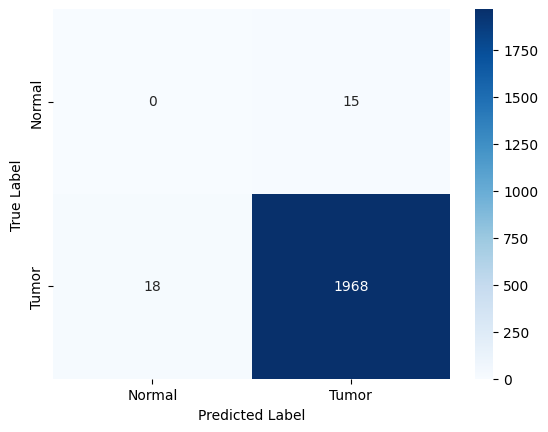

In [15]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<ipython-input-16-8bb2e2a2a263>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


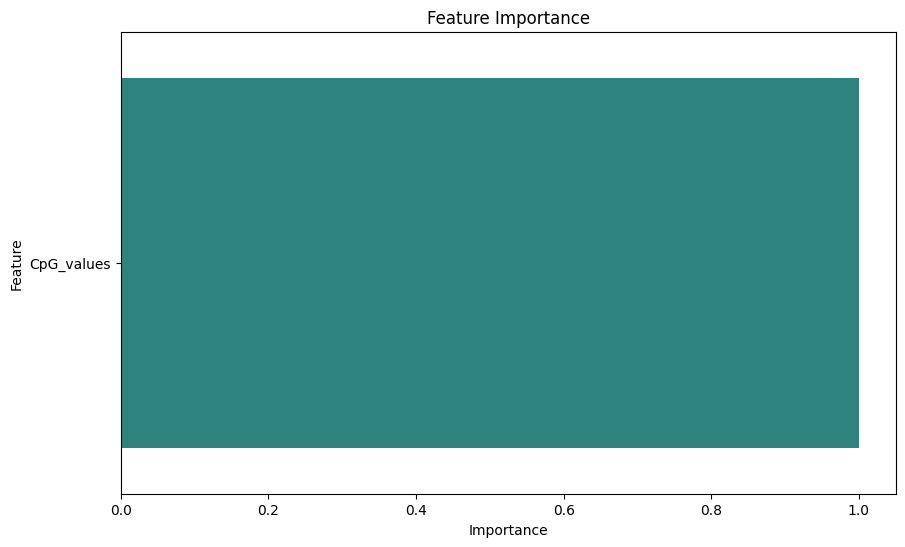

In [16]:
# Plot feature importance (if applicable)
# Random Forest has an attribute `feature_importances_` that can be used to plot feature importance
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.9892915258049488


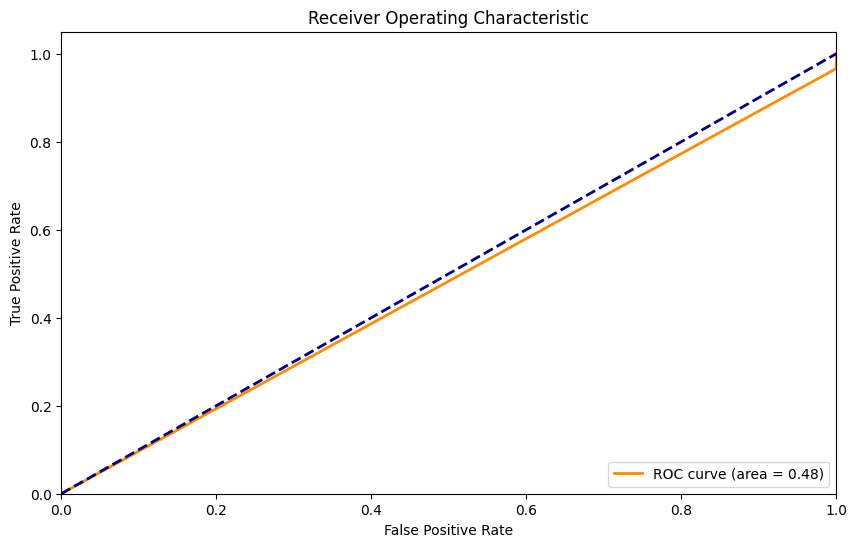

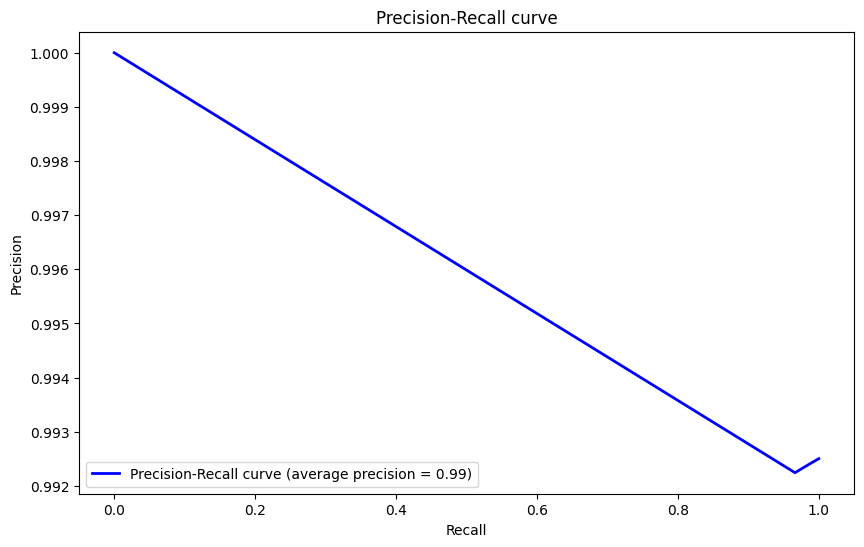

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (average precision = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")


Cross-Validation Scores: [0.98950525 0.98950525 0.98950525 0.98650675 0.98350825]
Mean CV Score: 0.9877061469265367


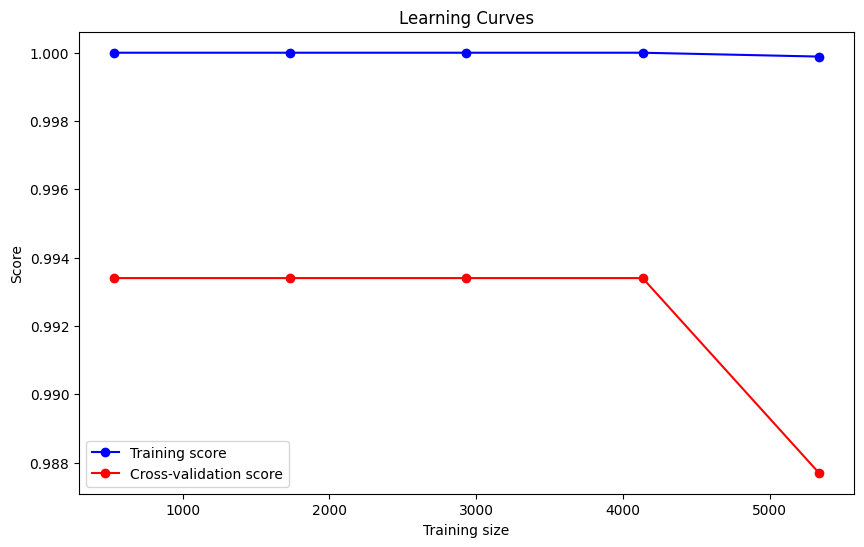

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()


In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting Example
boost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
boost_model.fit(X_train, y_train)
y_pred_boost = boost_model.predict(X_test)
print(f"Boosted Model Accuracy: {accuracy_score(y_test, y_pred_boost)}")



Boosted Model Accuracy: 0.992503748125937


In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Parameters from Randomized Search: {random_search.best_params_}")
print(f"Best Score from Randomized Search: {random_search.best_score_}")


Best Parameters from Randomized Search: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 10}
Best Score from Randomized Search: 0.9890771635327086
